In [17]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTModel
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import json

In [14]:
# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = 'google/vit-base-patch16-224'
CURRENT_DIR = os.getcwd()
DATA_DIR = "mtg_dataset"
MODEL_SAVE_DIR = os.path.join(CURRENT_DIR, "saved_models")
HISTORY_SAVE_DIR = os.path.join(CURRENT_DIR, "saved_losses")
EPOCHS = 15

# Chemins mis à jour
TRAIN_CSV = os.path.join(DATA_DIR, "Train.csv")
VAL_CSV = os.path.join(DATA_DIR, "Val.csv")
TEST_CSV = os.path.join(DATA_DIR, "Test.csv")

MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, f"best_model_vit_{EPOCHS}.pth")
HISTORY_SAVE_PATH = os.path.join(HISTORY_SAVE_DIR, f"vit_losses_{EPOCHS}.json")
CLASS_NAMES_PATH = "class_names.json"

In [4]:
# --- 1. PREPARATION DES LABELS ---
all_dfs = [pd.read_csv(TRAIN_CSV), pd.read_csv(VAL_CSV), pd.read_csv(TEST_CSV)]
combined_df = pd.concat(all_dfs)

TYPE_LIST = sorted(combined_df['type'].unique().tolist())
RARITY_LIST = sorted(combined_df['rarity'].unique().tolist())
COLOR_NAMES = ['Blanc', 'Bleu', 'Noir', 'Rouge', 'Vert', 'Incolore']

with open(CLASS_NAMES_PATH, 'w') as f:
    json.dump({'types': TYPE_LIST, 'rarities': RARITY_LIST}, f)

In [5]:
def get_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [6]:
# --- 2. DATASET ---
class MTGDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.type_map = {t: i for i, t in enumerate(TYPE_LIST)}
        self.rarity_map = {r: i for i, r in enumerate(RARITY_LIST)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # On s'assure que le chemin de l'image est correct (Linux/Windows)
        clean_img_path = row['image_path'].replace('\\', '/')
        img_path = os.path.join(self.img_dir, clean_img_path)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception:
            image = Image.new('RGB', (224, 224))

        if self.transform:
            image = self.transform(image)
        
        type_idx = self.type_map[row['type']]
        rarity_idx = self.rarity_map[row['rarity']]
        colors = torch.tensor([row['is_white'], row['is_blue'], row['is_black'], 
                               row['is_red'], row['is_green'], row['is_colorless']], dtype=torch.float32)

        return image, type_idx, rarity_idx, colors

In [7]:
# --- 3. ARCHITECTURE ViT ---
class ViTMTG(nn.Module):
    def __init__(self, num_types, num_rarities):
        super().__init__()
        self.vit = ViTModel.from_pretrained(MODEL_NAME)
        hidden_size = self.vit.config.hidden_size
        
        self.type_head = nn.Linear(hidden_size, num_types)
        self.rarity_head = nn.Linear(hidden_size, num_rarities)
        self.color_head = nn.Linear(hidden_size, 6)

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        cls_token = outputs.last_hidden_state[:, 0, :]
        return self.type_head(cls_token), self.rarity_head(cls_token), self.color_head(cls_token)


In [8]:
# --- 4. FONCTIONS DE CYCLE ---
def train_one_epoch(model, loader, optimizer, criterion_ce, criterion_bce):
    model.train()
    total_loss = 0
    for imgs, types, rarities, colors in tqdm(loader, desc="Training"):
        imgs, types, rarities, colors = imgs.to(DEVICE), types.to(DEVICE), rarities.to(DEVICE), colors.to(DEVICE)
        
        optimizer.zero_grad()
        out_t, out_r, out_c = model(imgs)
        
        loss = criterion_ce(out_t, types) + criterion_ce(out_r, rarities) + criterion_bce(out_c, colors)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def calcul_validation(model, loader, criterion_ce, criterion_bce):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, types, rarities, colors in tqdm(loader, desc="Validation"):
            imgs, types, rarities, colors = imgs.to(DEVICE), types.to(DEVICE), rarities.to(DEVICE), colors.to(DEVICE)
            out_t, out_r, out_c = model(imgs)
            loss = criterion_ce(out_t, types) + criterion_ce(out_r, rarities) + criterion_bce(out_c, colors)
            total_loss += loss.item()
    return total_loss / len(loader)

In [9]:
# Phase de Test
def evaluate(model, loader):
    model.eval()
    type_ok, rarity_ok, color_ok, perfect_ok, total = 0, 0, 0, 0, 0
    
    print("\n" + "="*50)
    print("DETAIL DES PREDICTIONS (SET DE TEST)")
    print("="*50)

    with torch.no_grad():
        for imgs, types, rarities, colors in loader:
            imgs, types, rarities, colors = imgs.to(DEVICE), types.to(DEVICE), rarities.to(DEVICE), colors.to(DEVICE)
            out_t, out_r, out_c = model(imgs)
            
            p_t = torch.argmax(out_t, dim=1)
            p_r = torch.argmax(out_r, dim=1)
            p_c = (torch.sigmoid(out_c) > 0.5).int()

            for i in range(len(imgs)):
                total += 1
                t_match = (p_t[i] == types[i]).item()
                r_match = (p_r[i] == rarities[i]).item()
                c_match = torch.equal(p_c[i], colors[i].int())
                
                type_ok += t_match
                rarity_ok += r_match
                color_ok += c_match
                if t_match and r_match and c_match: perfect_ok += 1

                if total <= 10: # On limite l'affichage pour plus de clarté
                    str_p_c = [COLOR_NAMES[k] for k, v in enumerate(p_c[i]) if v == 1]
                    str_t_c = [COLOR_NAMES[k] for k, v in enumerate(colors[i]) if v == 1]
                    print(f"\nCarte #{total}")
                    print(f"  TYPE    : Prédit [{TYPE_LIST[p_t[i]]:12}] | Réel [{TYPE_LIST[types[i]]:12}] {'✅' if t_match else '❌'}")
                    print(f"  RARETE  : Prédit [{RARITY_LIST[p_r[i]]:12}] | Réel [{RARITY_LIST[rarities[i]]:12}] {'✅' if r_match else '❌'}")
                    print(f"  COULEUR : Prédit {str(str_p_c):25} | Réel {str(str_t_c):25} {'✅' if c_match else '❌'}")

    print("\n" + "="*50)
    print(f"SCORE FINAL SUR {total} CARTES")
    print(f"Précision Type    : {100*type_ok/total:.1f}%")
    print(f"Précision Rareté  : {100*rarity_ok/total:.1f}%")
    print(f"Précision Couleur : {100*color_ok/total:.1f}%")
    print(f"CARTES PARFAITES  : {100*perfect_ok/total:.1f}%")
    print("="*50)

In [10]:
# Chargement dataset et training + save
def training(epochs=2):

    transform = get_transform()

    train_ds = MTGDataset(TRAIN_CSV, DATA_DIR, transform=transform)
    val_ds = MTGDataset(VAL_CSV, DATA_DIR, transform=transform)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

    model = ViTMTG(len(TYPE_LIST), len(RARITY_LIST)).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    
    # Scheduler pour réduire le LR si la val_loss ne baisse plus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)
    
    criterion_ce = nn.CrossEntropyLoss()
    criterion_bce = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')
    history = {"train_loss": [], "val_loss": []}

    print(f"Démarrage de l'entraînement sur {DEVICE}...")

    for epoch in range(epochs):
        # Phase de train
        avg_train_loss = train_one_epoch(model, train_loader, optimizer, criterion_ce, criterion_bce)
        
        # Phase de validation
        avg_val_loss = calcul_validation(model, val_loader, criterion_ce, criterion_bce)
        
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Sauvegarde si c'est le meilleur modèle vu jusqu'ici
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            status = "--- [SAVE] ---"
        else:
            status = ""

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.2e} {status}")

        with open(HISTORY_SAVE_PATH, 'w') as f:
            json.dump(history, f)

    

In [11]:
# Chargement dataset et training + save
training(EPOCHS)

Loading weights: 100%|██████████| 198/198 [00:00<00:00, 350.42it/s, Materializing param=layernorm.weight]                                 
ViTModel LOAD REPORT from: google/vit-base-patch16-224
Key                 | Status     | 
--------------------+------------+-
classifier.bias     | UNEXPECTED | 
classifier.weight   | UNEXPECTED | 
pooler.dense.weight | MISSING    | 
pooler.dense.bias   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Démarrage de l'entraînement sur cuda...


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


Epoch 1/15 | Train Loss: 2.9555 | Val Loss: 2.1715 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


Epoch 2/15 | Train Loss: 1.6932 | Val Loss: 1.6129 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch 3/15 | Train Loss: 0.8519 | Val Loss: 1.3564 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


Epoch 4/15 | Train Loss: 0.4326 | Val Loss: 1.1806 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Epoch 5/15 | Train Loss: 0.2574 | Val Loss: 1.1382 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Epoch 6/15 | Train Loss: 0.1761 | Val Loss: 1.0688 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Epoch 7/15 | Train Loss: 0.1307 | Val Loss: 1.0484 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch 8/15 | Train Loss: 0.1007 | Val Loss: 1.0381 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch 9/15 | Train Loss: 0.0794 | Val Loss: 1.0075 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Epoch 10/15 | Train Loss: 0.0642 | Val Loss: 1.0165 | LR: 5.00e-05 


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch 11/15 | Train Loss: 0.0529 | Val Loss: 0.9987 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Epoch 12/15 | Train Loss: 0.0448 | Val Loss: 0.9875 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Epoch 13/15 | Train Loss: 0.0384 | Val Loss: 0.9769 | LR: 5.00e-05 --- [SAVE] ---


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch 14/15 | Train Loss: 0.0331 | Val Loss: 0.9795 | LR: 5.00e-05 


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Epoch 15/15 | Train Loss: 0.0293 | Val Loss: 0.9742 | LR: 5.00e-05 --- [SAVE] ---


In [15]:
# Effectue le test
MODEL_TO_TEST = "best_model_vit_2.pth"

# model_path = best_model_path
model_path = os.path.join(MODEL_SAVE_DIR, MODEL_TO_TEST)

transform = get_transform()
test_ds = MTGDataset(TEST_CSV, DATA_DIR, transform=transform)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)
model = ViTMTG(len(TYPE_LIST), len(RARITY_LIST)).to(DEVICE)

# Recharger le meilleur modèle pour l'évaluation finale
print("\nChargement du meilleur modèle pour le test...")
model.load_state_dict(torch.load(model_path))
model.eval()
evaluate(model, test_loader) 

Loading weights: 100%|██████████| 198/198 [00:00<00:00, 282.03it/s, Materializing param=layernorm.weight]                                 
ViTModel LOAD REPORT from: google/vit-base-patch16-224
Key                 | Status     | 
--------------------+------------+-
classifier.bias     | UNEXPECTED | 
classifier.weight   | UNEXPECTED | 
pooler.dense.weight | MISSING    | 
pooler.dense.bias   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Chargement du meilleur modèle pour le test...

DETAIL DES PREDICTIONS (SET DE TEST)

Carte #1
  TYPE    : Prédit [Instant     ] | Réel [Artifact    ] ❌
  RARETE  : Prédit [rare        ] | Réel [rare        ] ✅
  COULEUR : Prédit ['Blanc']                 | Réel ['Noir']                  ❌

Carte #2
  TYPE    : Prédit [Instant     ] | Réel [Instant     ] ✅
  RARETE  : Prédit [uncommon    ] | Réel [uncommon    ] ✅
  COULEUR : Prédit []                        | Réel ['Noir', 'Rouge', 'Vert'] ❌

Carte #3
  TYPE    : Prédit [Instant     ] | Réel [Sorcery     ] ❌
  RARETE  : Prédit [uncommon    ] | Réel [rare        ] ❌
  COULEUR : Prédit []                        | Réel ['Noir', 'Vert']          ❌

Carte #4
  TYPE    : Prédit [Creature    ] | Réel [Creature    ] ✅
  RARETE  : Prédit [rare        ] | Réel [rare        ] ✅
  COULEUR : Prédit []                        | Réel ['Noir']                  ❌

Carte #5
  TYPE    : Prédit [Creature    ] | Réel [Creature    ] ✅
  RARETE  : Prédit [rar

Losses du modèle vit_losses_15 chargées.


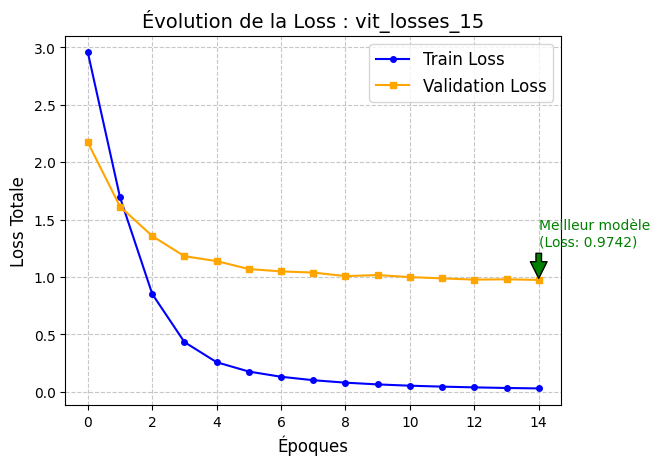

In [19]:
# Affiche la courbe de loss
LOSSES_TO_VIEW = f"vit_losses_{EPOCHS}.json"
loss_path = os.path.join(HISTORY_SAVE_DIR, LOSSES_TO_VIEW)

# Chargement des données
try:
    with open(loss_path, "r") as f:
        history = json.load(f)
    
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    model_name = os.path.basename(loss_path)
    print(f"Losses du modèle {Path(model_name).stem} chargées.")
except FileNotFoundError:
    print(f"Erreur : Le fichier {loss_path} n'a pas été trouvé.")
    train_losses, val_losses = [], []
    model_name = "Inconnu"

# --- GÉNÉRATION DU GRAPHIQUE ---
if train_losses:
    plt.title(f"Évolution de la Loss : {Path(model_name).stem}", fontsize=14)

    # Tracé des courbes
    plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o', markersize=4)
    plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='-', marker='s', markersize=4)

    # Configuration des axes
    plt.xlabel("Époques", fontsize=12)
    plt.ylabel("Loss Totale", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotation du point minimal de validation
    min_val_loss = min(val_losses)
    min_epoch = val_losses.index(min_val_loss)
    plt.annotate(f'Meilleur modèle\n(Loss: {min_val_loss:.4f})',
                 xy=(min_epoch, min_val_loss), 
                 xytext=(min_epoch, min_val_loss + (max(train_losses)*0.1)),
                 arrowprops=dict(facecolor='green', shrink=0.05),
                 fontsize=10, color='green')

    plt.show()

In [47]:
import gc

# 1. Delete the variable
del model
del test_loader

# 2. Trigger Python's garbage collector
gc.collect()

# 3. Clear the PyTorch cache
torch.cuda.empty_cache()